# Plot fn

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def gr_dataset(X, y, title=None, show=True):
    """plot 2-class dataset. Different colors for different labels"""
    color = np.vectorize(lambda l: "green" if l == 1 else "blue")

    plt.scatter(*X.T, c=color(y))
    x = np.linspace(0, 1, 200)
    plt.ylim(0, 1)
    if title:
        plt.title(title)
    if show:
        plt.show()


def gr_classifier(classifier, X, y, margin=False, title="?"):
    """plot dataset and classifier margin"""

    # these are to plot the contour
    x_range = np.linspace(0, 1, 50)
    y_range = np.linspace(0, 1, 50)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    z = classifier.predict(np.array((np.ravel(x_grid), np.ravel(y_grid))).T)
    z_grid = z.reshape(x_grid.shape)

    plt.contour(x_grid, y_grid, z_grid, [0], colors="k")

    if margin:
        plt.contour(x_grid, y_grid, z_grid, [-1, 1], colors="k", linestyles="dashed")

    gr_dataset(X, y, show=False)
    plt.title(title)
    plt.show()

In [20]:
from pathlib import Path
BASE_PATH = Path("/home/anto/Downloads/1000_samples_experiments")
EXP_TIMESTAMP = "1683253453.8699663"

# Load Dataset Info in df

In [3]:
import pandas as pd
from experiments.synthetic_datasets.common import load_dataset

sinusoid_ds_info = []
pacman_ds_info = []
all_ds_info = []
for ds_f in Path(BASE_PATH / "synthetic_datasets/datasets").iterdir():
    ds = load_dataset(ds_f)
    if ds.params.get("a", None):
        pacman_ds_info.append({"id": ds.id, **ds.params, **ds.complexity_report})
    else:
        sinusoid_ds_info.append({"id": ds.id, **ds.params,**ds.complexity_report})
    all_ds_info.append({"id": ds.id, **ds.params, **ds.complexity_report})

pacman_ds_info = pd.DataFrame(pacman_ds_info)
sinusoid_ds_info = pd.DataFrame(sinusoid_ds_info)
all_ds_info = pd.DataFrame(all_ds_info)
all_ds_info.sample(5)

,id,n,a,r,p,dim,gamma,test_size,seed,n_samples,n_features,score,complexities,prior_probability,beta,rho,theta,sep,clusters_per_class
9,be6db084d08274d5ad51d9abb135fe44,300,0.5,0,1,2.0,10.0,0.3,3653403230,300,2,0.303,"{'f1': 0.381, 'f1v': 0.233, 'f2': 0.149, 'f3':...","[0.5, 0.5]",NaN,NaN,NaN,NaN,NaN
20,f20904a07598777e2e4232185da84834,1000,NaN,0,1,NaN,NaN,0.3,2735729614,1000,2,0.378,"{'f1': 0.302, 'f1v': 0.15, 'f2': 0.986, 'f3': ...","[0.5, 0.5]",95.0,0.2,10.0,NaN,NaN
4,1e9ec10719c9b8e994629b57f501b861,1000,0.5,0,1,2.0,10.0,0.3,2735729614,1000,2,0.292,"{'f1': 0.371, 'f1v': 0.228, 'f2': 0.147, 'f3':...","[0.5, 0.5]",NaN,NaN,NaN,NaN,NaN
26,52f8e095edca99abf521370e7be6e753,1000,0.1,0,1,2.0,10.0,0.3,3653403230,1000,2,0.215,"{'f1': 0.211, 'f1v': 0.118, 'f2': 0.051, 'f3':...","[0.5, 0.5]",NaN,NaN,NaN,NaN,NaN
10,447ab89cef034bc4e3e6f24a65f2a7f0,1000,NaN,0,1,3.0,NaN,0.3,3653403230,1000,3,0.286,"{'f1': 0.56, 'f1v': 0.074, 'f2': 0.167, 'f3': ...","[0.5, 0.5]",NaN,NaN,NaN,2.0,2.0


# Load experiments results in df

In [25]:
import pandas as pd
from budgetsvm import optimization

df = pd.read_json(BASE_PATH / f"results/{EXP_TIMESTAMP}.json")

df["budget_percentage"] = df["model_name"].apply(
    lambda x: float(x.split("_")[0]) if "full" not in x else 1.0
)

total_train_time_sec = df.train_time.sum()
df.train_time = df.train_time.div(60)
df = df.rename({"train_time": "train_time_min"}, axis=1)

df_success = df.dropna().copy()
# df_success = df.copy()
# df_success["score"] = df_success.score.apply(lambda x: x if type(x)==float else "0.0")

df_success = df_success.astype(
    {
        "dataset": "string",
        "model_name": "string",
        "optimal": "bool",
        "params": "object",
        "score": "float",
        "budget": "float",
        "num_sv": "float",
        "train_time_min": "float",
    }
)


full_budget_score = df_success.query("budget==inf")[["dataset", "score"]]
df_success = df_success.join(
    full_budget_score.set_index("dataset"), on="dataset", rsuffix="_full_budget"
)
df_success["score_ratio"] = df_success["score"] / df_success["score_full_budget"]

# df_success["dataset"] = df_success["dataset"].apply(lambda x: x[-10:])

df_success.query("dataset == '6928fa1a93de586a988e1419fc3b048b'")

,dataset,model_UUID,model_name,optimal,params,score,budget,num_sv,train_time_min,budget_percentage,score_full_budget,score_ratio
16,6928fa1a93de586a988e1419fc3b048b,459d0328-6f22-4d07-874c-45d748e0655e,full_budget,True,"{'C': 1, 'kernel': 'PrecomputedKernel(Gaussian...",0.860000,inf,137.0,2.839228,1.0,0.86,1.000000
17,6928fa1a93de586a988e1419fc3b048b,781f1d57-54cb-4592-b07a-f672ae81ab21,0.90_budget,False,"{'C': 10, 'kernel': 'PrecomputedKernel(Gaussia...",0.613333,123.0,123.0,32.539333,0.9,0.86,0.713178
18,6928fa1a93de586a988e1419fc3b048b,a633db8a-3dc0-4ece-92d1-a315d0054123,0.80_budget,False,"{'C': 100, 'kernel': 'PrecomputedKernel(Linear...",0.733333,109.0,3.0,32.940733,0.8,0.86,0.852713
19,6928fa1a93de586a988e1419fc3b048b,62a7cd09-fb44-49ec-b1c9-2ff013c67894,0.70_budget,False,"{'C': 10, 'kernel': 'PrecomputedKernel(Polynom...",0.703333,95.0,6.0,32.073877,0.7,0.86,0.817829
20,6928fa1a93de586a988e1419fc3b048b,c32a1764-6499-4fdd-bce6-bd65e9001277,0.60_budget,False,"{'C': 100, 'kernel': 'PrecomputedKernel(Gaussi...",0.583333,82.0,82.0,22.205601,0.6,0.86,0.678295
21,6928fa1a93de586a988e1419fc3b048b,72f6d20b-093d-4c3b-b1db-b3162d6bd174,0.50_budget,False,"{'C': 10, 'kernel': 'PrecomputedKernel(Gaussia...",0.576667,68.0,68.0,20.462914,0.5,0.86,0.670543
22,6928fa1a93de586a988e1419fc3b048b,a0af5ea7-204b-4065-b78f-3da9759e2f97,0.40_budget,False,"{'C': 10, 'kernel': 'PrecomputedKernel(Gaussia...",0.530000,54.0,55.0,21.548683,0.4,0.86,0.616279
23,6928fa1a93de586a988e1419fc3b048b,0c207ff5-65f5-4ddb-832d-a0ef2aaaa84c,0.30_budget,False,"{'C': 0.1, 'kernel': 'PrecomputedKernel(Polyno...",0.606667,41.0,9.0,32.948067,0.3,0.86,0.705426


In [28]:
import pickle

with open(BASE_PATH / "results" / "models" / "a0af5ea7-204b-4065-b78f-3da9759e2f97.pkl", "rb") as fp:
    model = pickle.load(fp)
    
model.alpha_

array([1.05657086e+00, 1.06855504e+00, 1.09956635e+00, 1.14254018e+00,
       1.06741958e+00, 1.30387215e+00, 1.29224796e+00, 1.07013850e+00,
       2.00460169e+00, 5.50402014e+00, 2.45286941e-07, 5.50243012e+00,
       1.00989974e+00, 2.84366459e+00, 1.01275883e+00, 2.84191052e+00,
       1.04540851e+00, 2.30415791e+00, 1.00432437e+00, 1.00158805e+00,
       1.11654752e+00, 1.06582685e+00, 1.41276813e+00, 1.39784611e+00,
       1.00207996e+00, 1.29827432e+00, 1.02358503e+00, 1.05794489e+00,
       9.98554443e-01, 1.00568844e+00, 1.03643029e+00, 1.32088835e+00,
       1.04817592e+00, 1.17315574e+00, 1.32323270e+00, 1.13996778e+00,
       1.10388740e+00, 1.10910912e+00, 9.98554443e-01, 9.98554443e-01,
       1.00155653e+00, 2.29998700e+00, 1.01693978e+00, 1.14077326e+00,
       1.17552169e+00, 1.01164505e+00, 1.03868456e+00, 1.00424314e+00,
       1.22182810e+00, 9.98566054e-01, 2.00558031e+00, 1.10305143e+00,
       1.05382346e+00, 1.00719901e+00, 1.00202049e+00])

In [5]:
import datetime

print(f"{datetime.timedelta(seconds=total_train_time_sec)} tot. training time")

1 day, 19:45:01.158577 tot. training time


In [6]:
df.dataset.unique()

array(['a5430a99ae3cb838936063502333466d',
       'fba90d74afdad10779cebbc859a1e7f9',
       '6928fa1a93de586a988e1419fc3b048b',
       'ceebcc3e2a6d3fc443219778614be3e8',
       'f20904a07598777e2e4232185da84834',
       '2fa60990c090efd900bbb0f2ad794606',
       '6d1b8b19811bbc4a07801d72591e29d1',
       '0dca4f0d524c6f06134b63c6396e360e',
       '9a198c96a10ee93b141abe06073f32ec',
       '52f8e095edca99abf521370e7be6e753',
       '9a36d69d0a4633c000cb48abbcbf0cb3',
       '0065ebb558519585b7ce214827e64d9a',
       '3a17afc3942cba38f05410a37c308959',
       '1e9ec10719c9b8e994629b57f501b861',
       '35c6a0f6e03b4d9fd154fe388329e6b8',
       '305c24150bc8507ac447cf629642d77f',
       '6e4b4841910190abd21a4ca730b451c1',
       '8f19e326f2c9e4cd9158d44a04d0354e'], dtype=object)

In [7]:
all_model_params = pd.json_normalize(df_success["params"])
display(all_model_params.kernel.value_counts())
print()
display(all_model_params.C.value_counts())

PrecomputedKernel(GaussianKernel())               39
PrecomputedKernel(GaussianKernel(sigma=0.1))      34
PrecomputedKernel(PolynomialKernel(2))            26
PrecomputedKernel(GaussianKernel(sigma=0.01))     20
PrecomputedKernel(PolynomialKernel(5))            12
PrecomputedKernel(LinearKernel())                  6
PrecomputedKernel(PolynomialKernel(10))            6
PrecomputedKernel(GaussianKernel(sigma=1e-05))     1
Name: kernel, dtype: int64

100.0    57
1.0      53
10.0     29
0.1       5
Name: C, dtype: int64

# Results by dataset type

In [9]:
def plot_res(dataframe, hue, metrics=["score"]):
    pal = sns.color_palette("hls", len(dataframe["dataset_id"].unique()))
    
    fig, axs = plt.subplots(2,3, figsize=(16,10))
    
    for ax in axs.flat[:2]:
        ax.set_xlim((0.2, 1.1))
        ax.set_ylim((0.2, 1.1))
        ax.set_box_aspect(1)
    
    axs = iter(axs.flat)
                
    ax = next(axs)
    
    g = sns.lineplot(data=group, x="budget_percentage", y="score", hue="dataset_id", ax=ax, legend=False, palette=pal)
    ax.axhline(y=0.5, linestyle="--", linewidth=0.5)
    
        
    ax = next(axs)
    ax.axline((0, 0), (1, 1), linestyle="--", linewidth=0.5)
    sns.lineplot(
        data=dataframe,
        x="budget_percentage",
        y="score_ratio",
        hue=hue,
        orient="x",
        legend=False,
        ax=ax,
        palette=pal
    )
    g = sns.scatterplot(
        data=dataframe,
        x="budget_percentage",
        y="score_ratio",
        hue=hue,
        style="optimal",
        size="optimal",
        markers={True: "o", False: "X"},
        ax=ax,
        palette=pal
    )
    legend = g.get_legend()
    legend.set_bbox_to_anchor((0.9, 0.7))
    
    for label_text_obj in legend.get_texts():
        ds_id_label = label_text_obj.get_text()
        
        metrics_str = ""
        try:
            ds_info = all_ds_info.query("id == @ds_id_label").iloc[0]
            if "score" in metrics:
                metrics_str += f"score: {ds_info['score']}"
            for metric_key in metrics:
                if metric_key in ds_info['complexities']:
                    metrics_str += f" {metric_key}: {ds_info['complexities'][metric_key]}"
        except:
            pass
        
        if ds_id_label=="dataset_id":
            label_text_obj.set_text("Datasets info")
        elif ds_id_label == "optimal":
            label_text_obj.set_text("Optimal")
        else:
            l = f"[{ds_id_label[-5:]}] {metrics_str}" 
            label_text_obj.set_text(l)
    
    sns.despine()
    
    
    next(axs).axis('off')
    
    
    for ds_id in dataframe["dataset_id"].unique(): 
        ax = next(axs)
        ds = load_dataset(PATH(BASE_PATH / f"synthetic_datasets/datasets/{ds_id}.json"))
        sns.scatterplot(x=ds.X.T[0], y=ds.X.T[1], hue=ds.y, palette="deep", legend=False, ax=ax)
        #ax.scatter(*ds.X.T, c=ds.y)
        ax.title.set_text(ds_id[-10:])
        ax.set_box_aspect(1)
    
    plt.show()


from experiments.synthetic_datasets.common import load_dataset


def plot_group_ds(dataframe):
    ds_ids = dataframe["dataset_id"].unique().tolist()

    fig, axs = plt.subplots(1, 3, figsize=(10, 6), sharex=True, sharey=True)
    flat_axs = axs.flat
    for ds_id, ax in zip(ds_ids, flat_axs):
        ds = load_dataset(PATH(BASE_PATH / f"synthetic_datasets/datasets/{ds_id}.json"))
        sns.scatterplot(x=ds.X.T[0], y=ds.X.T[1], hue=ds.y, palette="deep", legend=False, ax=ax)
        #ax.scatter(*ds.X.T, c=ds.y)
        ax.title.set_text(ds_id[-10:])
        ax.set_box_aspect(1)

    plt.show()
    

In [10]:
from experiments.synthetic_datasets.common import load_dataset
import matplotlib.gridspec as gridspec

def plot_res(dataframe, hue, metrics=["score"]):
    pal = sns.color_palette(None, len(dataframe["dataset_id"].unique()))
        
    fig, axs = plt.subplots(1,2, figsize=(14,6))
    
    for ax in axs.flat:
        ax.set_xlim((0.2, 1.1))
        ax.set_ylim((0.2, 1.1))
        ax.set_box_aspect(1)
    
    axs = iter(axs.flat)
                
    ax = next(axs)
    
    g = sns.lineplot(data=group, x="budget_percentage", y="score", hue="dataset_id", ax=ax, legend=False, palette=pal)
    ax.axhline(y=0.5, linestyle="--", linewidth=0.5)
    
        
    ax = next(axs)
    ax.axline((0, 0), (1, 1), linestyle="--", linewidth=0.5)
    sns.lineplot(
        data=dataframe,
        x="budget_percentage",
        y="score_ratio",
        hue=hue,
        orient="x",
        legend=False,
        ax=ax,
        palette=pal
    )
    g = sns.scatterplot(
        data=dataframe,
        x="budget_percentage",
        y="score_ratio",
        hue=hue,
        style="optimal",
        size="optimal",
        markers={True: "o", False: "X"},
        ax=ax,
        palette=pal
    )
    legend = g.get_legend()
    legend.set_bbox_to_anchor((0.8, 0.4))
    
    # map dataset id to color. Has to be consistent in all plots
    cmap = dict(zip([t.get_text() for t in legend.get_texts() if not any(s in t.get_text() for s in ["optimal", "dataset_id"])], pal))

    
    for label_text_obj in legend.get_texts():
        ds_id_label = label_text_obj.get_text()
        l = f"{ds_id_label[-10:]}" 
        label_text_obj.set_text(l)
    
    sns.despine()
    
    
    ds_ids = dataframe["dataset_id"].unique().tolist()

    fig, axs = plt.subplots(1, 3, figsize=(14, 6), sharex=True, sharey=True)
    flat_axs = axs.flat
    for ds_id, ax in zip(ds_ids, flat_axs):
        ds = load_dataset(Path(BASE_PATH / f"synthetic_datasets/datasets/{ds_id}.json"))
        sns.scatterplot(x=ds.X.T[0], y=ds.X.T[1], hue=ds.y, palette="deep", legend=False, ax=ax)
        
        metrics_str = ""

        if "score" in metrics:
            metrics_str += f"score: {ds.complexity_report['score']}"
        for metric_key in metrics:
            if metric_key in ds.complexity_report['complexities']:
                metrics_str += f" {metric_key}: {ds.complexity_report['complexities'][metric_key]}"
        
        l = f"{ds_id[-10:]}\n{metrics_str}" 
        
        ax.title.set_text(l)
        ax.title.set_color(cmap[ds_id])
        ax.set_box_aspect(1)
    
    plt.show()
   

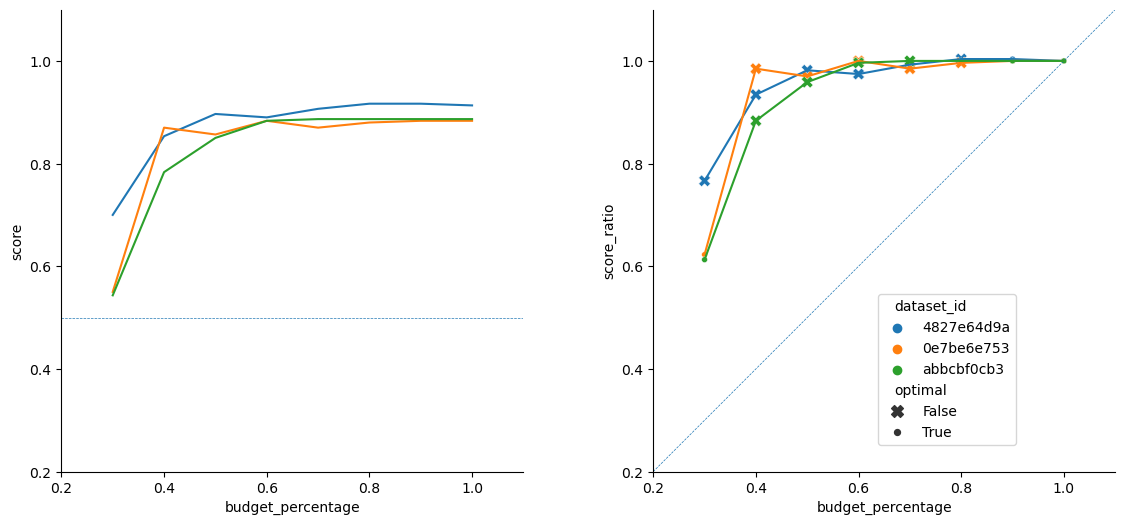

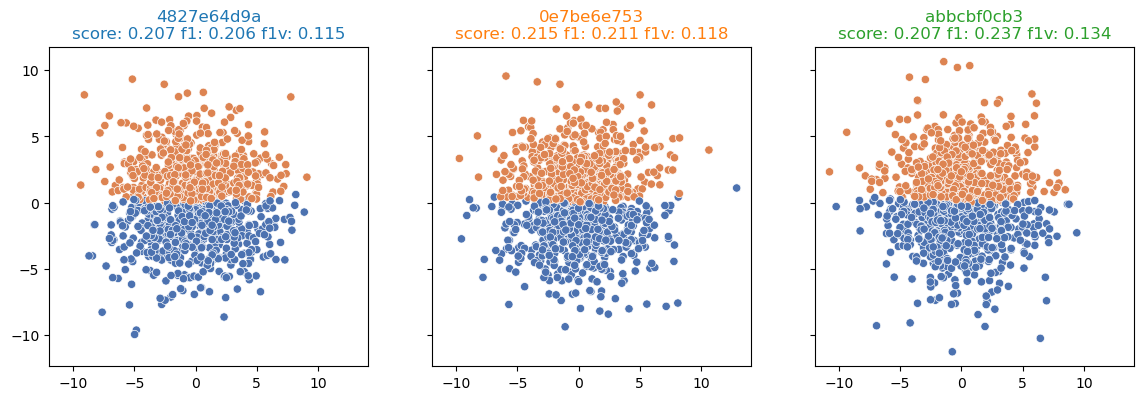

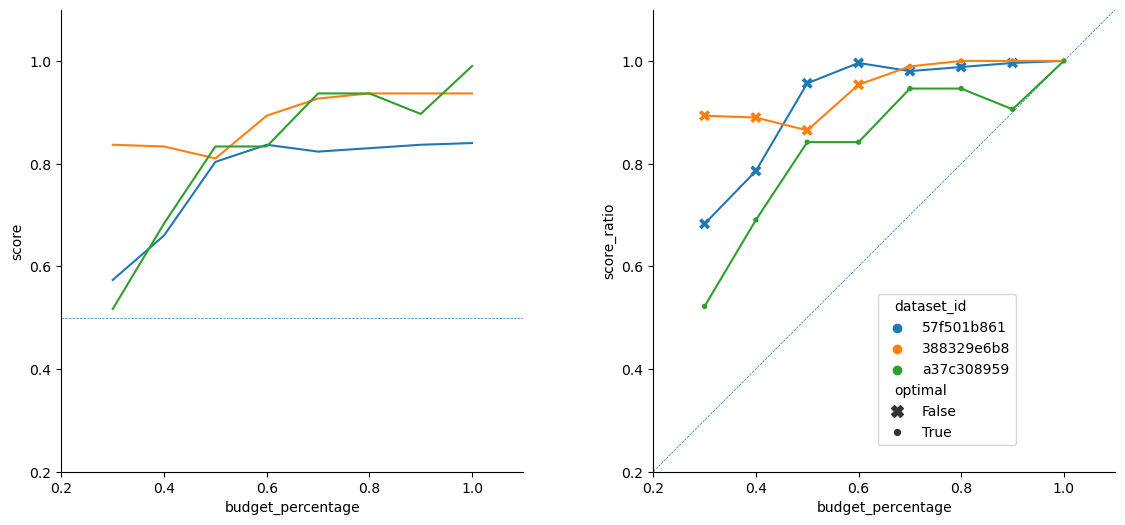

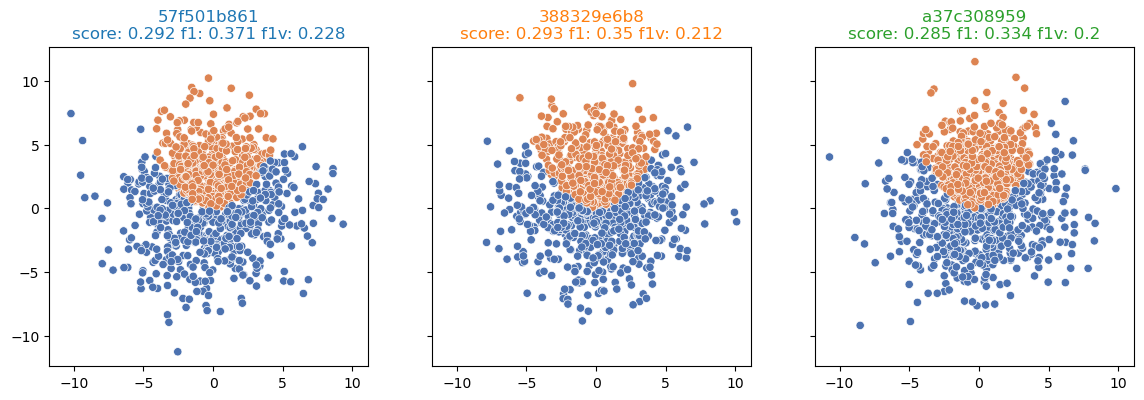

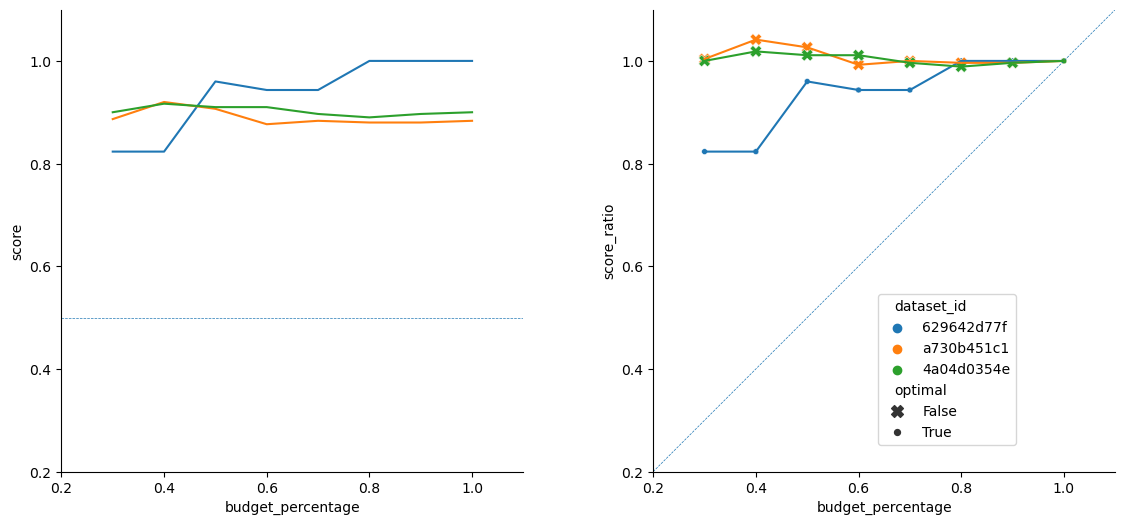

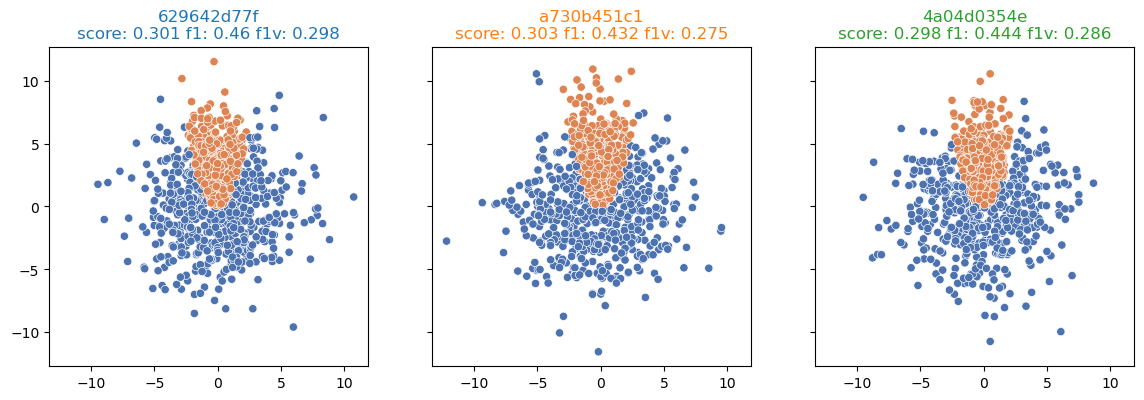

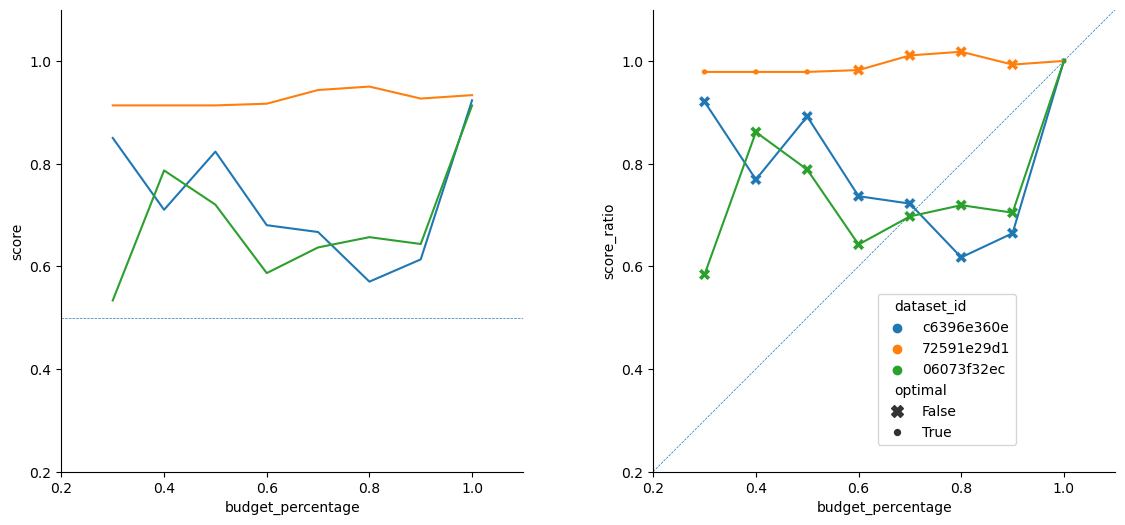

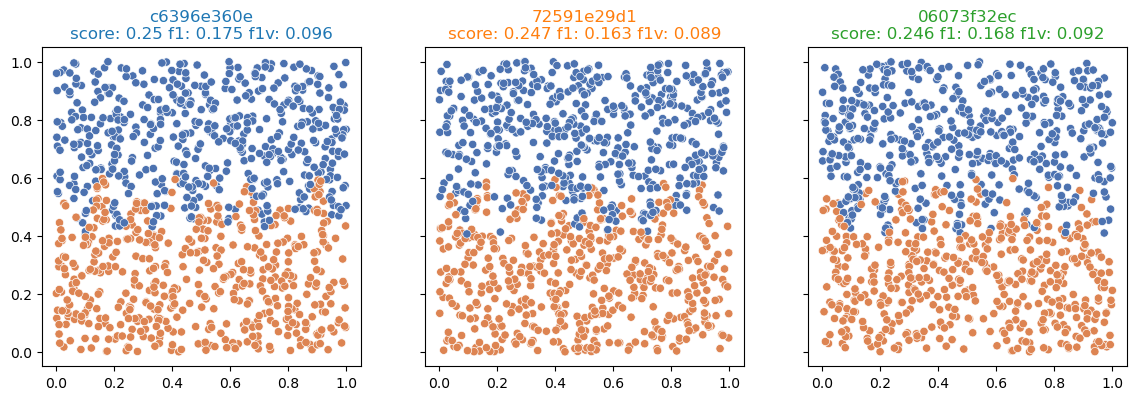

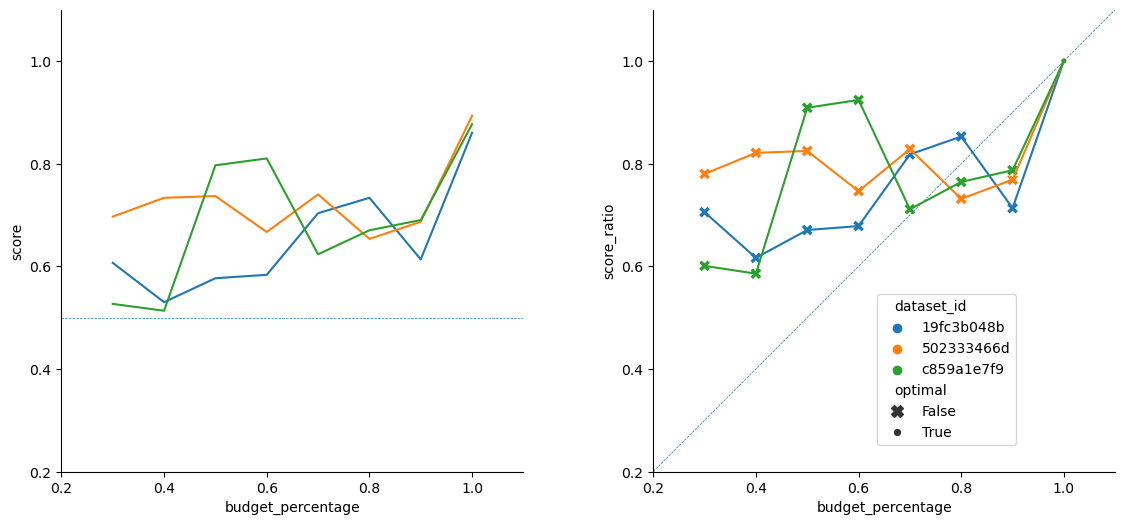

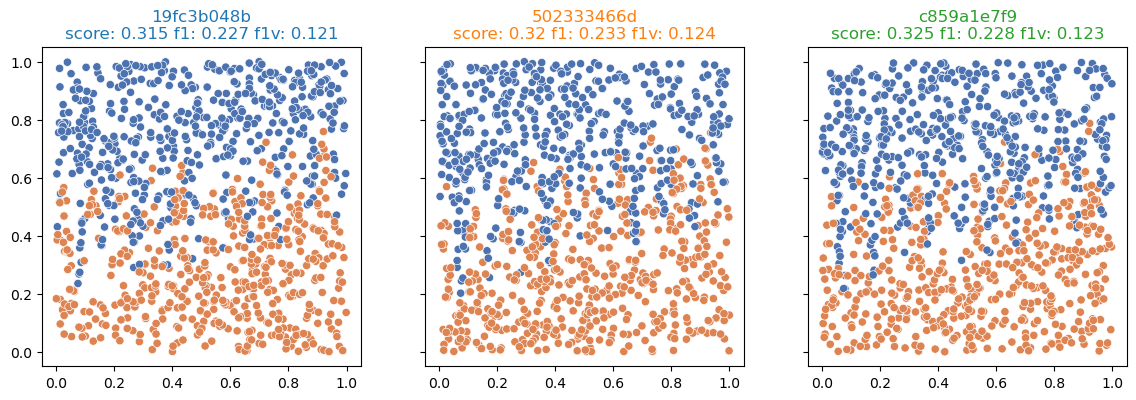

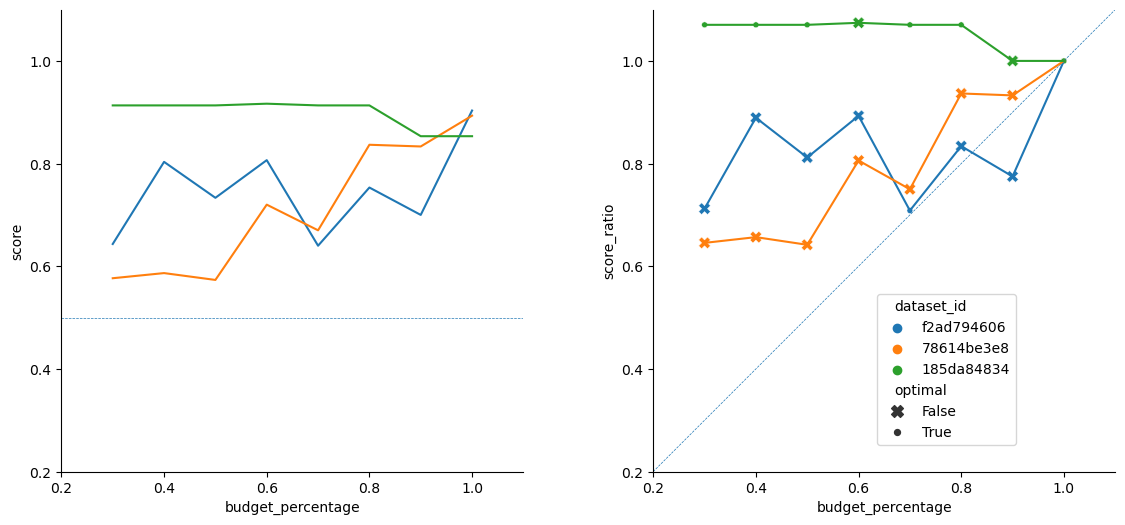

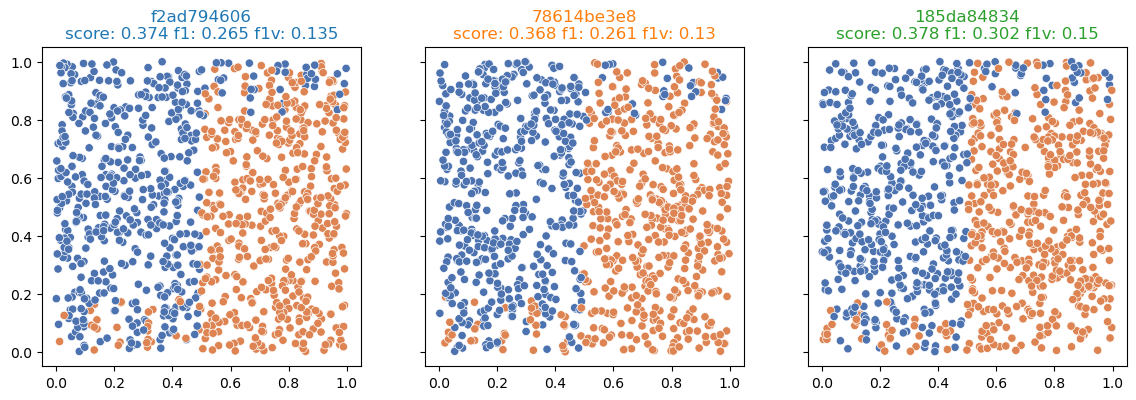

In [13]:
res_df = (
    df_success.set_index("dataset")
    .join(all_ds_info.set_index("id"), rsuffix="_ds_param")
    .reset_index()
    .rename(
        {
            "index": "dataset_id",
        },
        axis=1,
    )
)

sigmoid_res = res_df.query("a.isnull()").dropna(axis=1).copy()
pacman_res = res_df.query("rho.isnull()").dropna(axis=1).copy()

metrics = ["score", "f1", "f1v"]

id_map = {}
for i, group in pacman_res.groupby(by=["a", "r", "p"]):
    ds_ids = group.dataset_id.unique().tolist()
    grouped_id = "-".join([x[-5:] for x in ds_ids])
    for ds_id in ds_ids:
        id_map[ds_id] = grouped_id
    plot_res(group, "dataset_id", metrics)
    #plot_group_ds(group)

for i, group in sigmoid_res.groupby(by=["beta", "rho", "theta"]):
    ds_ids = group.dataset_id.unique().tolist()
    grouped_id = "-".join([x[-5:] for x in ds_ids])
    for ds_id in ds_ids:
        id_map[ds_id] = grouped_id
    plot_res(group, "dataset_id", metrics)
    #plot_group_ds(group)


pacman_res["grouped_id"] = pacman_res.dataset_id.apply(lambda x: id_map[x])
sigmoid_res["grouped_id"] = sigmoid_res.dataset_id.apply(lambda x: id_map[x])

# Results all datasets 2

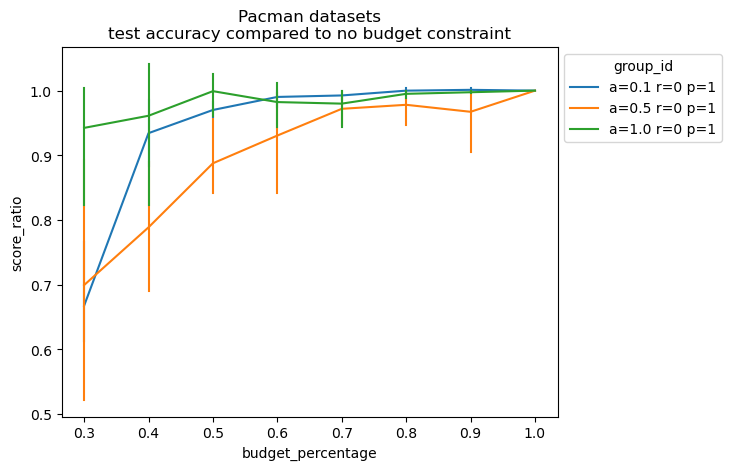

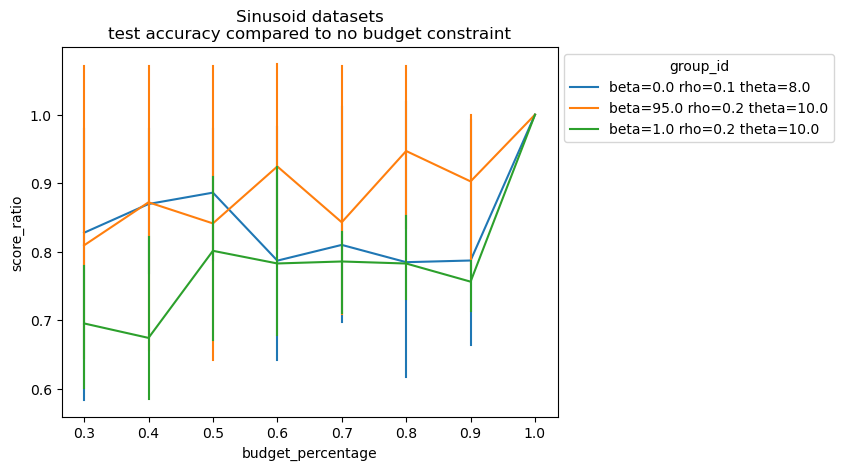

In [41]:
res_df = (
    df_success.set_index("dataset")
    .join(all_ds_info.set_index("id"), rsuffix="_ds_param")
    .reset_index()
    .rename(
        {
            "index": "dataset_id",
        },
        axis=1,
    )
)

pacman_res = res_df.query("rho.isnull()").dropna(axis=1).copy()

pacman_res["group_id"] = pacman_res.apply(lambda x: f"a={x.a} r={x.r} p={x.p}",axis=1)
ax = sns.lineplot(
    data=pacman_res,
    x="budget_percentage",
    y="score_ratio",
    hue="group_id",
    orient="x",
    legend=True,
    err_style="bars", 
    errorbar=lambda x: (x.min(), x.max())
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Pacman datasets\ntest accuracy compared to no budget constraint");
plt.show()

sinusoid_res = res_df.query("a.isnull()").dropna(axis=1).copy()
sinusoid_res["group_id"] = sinusoid_res.apply(lambda x: f"beta={x.beta} rho={x.rho} theta={x.theta}",axis=1)
ax = sns.lineplot(
    data=sinusoid_res,
    x="budget_percentage",
    y="score_ratio",
    hue="group_id",
    orient="x",
    legend=True,
    err_style="bars", 
    errorbar=lambda x: (x.min(), x.max())
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Sinusoid datasets\ntest accuracy compared to no budget constraint");

# Results all datasets

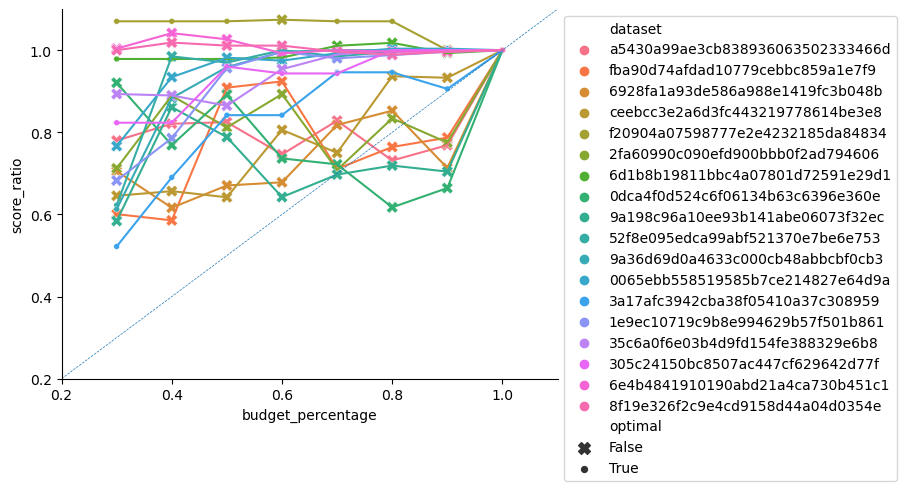

In [27]:
fig, ax = plt.subplots()

sns.lineplot(
    data=df_success,
    x="budget_percentage",
    y="score_ratio",
    hue="dataset",
    orient="x",
    legend=False,
    ax=ax,
)
# g = sns.scatterplot(
#     data=df_success,
#     x="budget_percentage",
#     y="score_ratio",
#     hue="dataset",
#     style="optimal",
#     size="optimal",
#     markers={True: "o", False: "X"},
#     ax=ax,
# )
plt.axline((0, 0), (1, 1), linestyle="--", linewidth=0.5)

ax.set(xlim=(0.2, 1.1))
ax.set(ylim=(0.2, 1.1))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

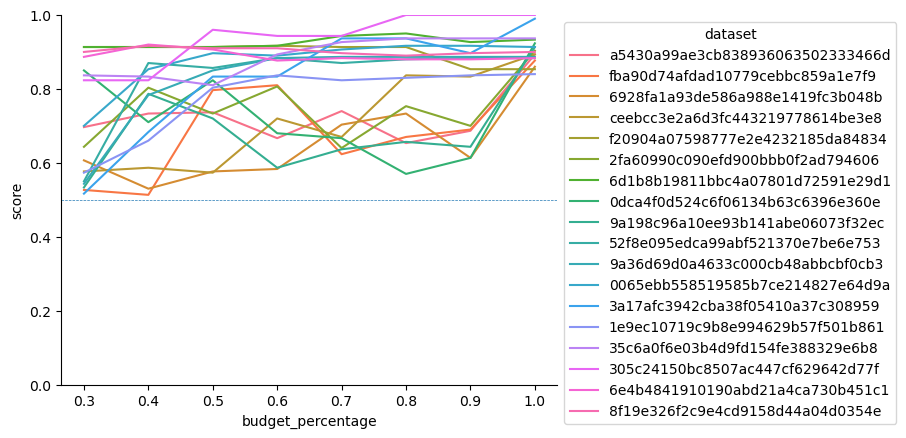

In [28]:
g = sns.lineplot(data=df_success, x="budget_percentage", y="score", hue="dataset")

plt.axhline(y=.5, linestyle="--", linewidth=.5)

g.set(ylim=(0.0, 1.0));

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

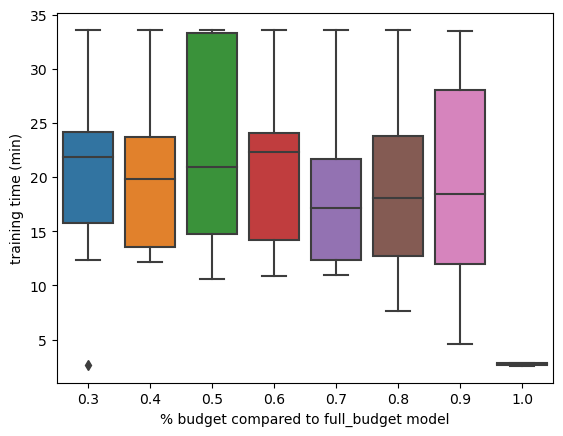

In [29]:
ax = sns.boxplot(
    data=df,
    x="budget_percentage",
    y="train_time_min"
)
ax.set(xlabel='% budget compared to full_budget model', ylabel='training time (min)');

# Same budget as unconstrained model - GridSearchCV

    full_budget_model = GridSearchCV(SVC(), params)
    100_p_model = GridSearchCV(SVC(budget=full_budget_model.num_SV), params)
    

In [1]:
import pandas as pd
from budgetsvm import optimization

df = pd.read_json("/home/anto/Downloads/experiments/results/1680714507.691396_100per_budget.json")
df

,dataset,model_UUID,model_name,optimal,params,obj_fn_value,score,budget,num_sv,train_time
0,c909c284a99cdf44d8d51d2ea62d334d,e313b4e3-bea0-4183-ae2d-718bad153d76,unconstrained,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",56.298203,0.911111,inf,63,23.127109
1,c909c284a99cdf44d8d51d2ea62d334d,b9cb4076-d425-4ac0-b2ba-c3136d8ec27a,100perc_budget,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",56.298203,0.911111,inf,63,22.502951
2,4866a56c176db9624e6d8bb02f2de8e1,190ba03a-058a-4eba-a2ec-3f44fbfa1b26,unconstrained,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",50.917990,0.933333,inf,51,22.412940
3,4866a56c176db9624e6d8bb02f2de8e1,8376921d-c5b3-4b13-a3c3-67fde653de55,100perc_budget,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",50.917990,0.933333,inf,51,22.564765
4,6340ead3f8a9ea762eaf5c2132fc757a,bae6ba03-0073-41ff-8e6b-d7c68e88eaaf,unconstrained,True,"{'C': 100.0, 'kernel': 'GaussianKernel(sigma=0...",231.114726,0.933333,inf,47,22.563301
5,6340ead3f8a9ea762eaf5c2132fc757a,e517287e-881b-4070-bbf5-e8a3b26c5423,100perc_budget,True,"{'C': 100.0, 'kernel': 'GaussianKernel(sigma=0...",231.114726,0.933333,inf,47,22.390710
6,ff89c17b0ee181abd72e691a10b27bf9,6d191cb9-a3bc-44c2-9212-74189a19737d,unconstrained,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",41.277807,0.966667,inf,67,22.154327
7,ff89c17b0ee181abd72e691a10b27bf9,5abd087e-1acb-4bae-87d8-dbf364900db5,100perc_budget,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",41.277807,0.966667,inf,67,22.068701
8,96ee0f04878ee282e3470b3df861b457,9ddb2599-968e-4a0b-988d-a87ae1cebcc8,unconstrained,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",3.326407,1.000000,inf,14,21.458484
9,96ee0f04878ee282e3470b3df861b457,18d0d1c1-15d6-4763-9d65-05a1c3a89fcd,100perc_budget,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",3.326407,1.000000,inf,14,21.599665


In [2]:
total_train_time_sec = df.train_time.sum()
df.train_time = df.train_time.div(60)
df = df.rename({"train_time": "train_time_min"}, axis=1)
df["dataset_short"] = df["dataset"].apply(lambda x: x[-10:])
df.set_index("dataset_short")

def dict_eq(d1,d2):
    return list(d1.keys()).sort() == list(d2.keys()).sort() and list(d2.items()).sort() == list(d2.items()).sort()

res = {}
for ds, group in df.groupby("dataset_short"):
    unc = group.query("model_name=='unconstrained'").iloc[0]
    bud = group.query("model_name=='100perc_budget'").iloc[0]
    
    res[ds] = {
        "same_obj": unc["obj_fn_value"] == bud["obj_fn_value"],
        "same_score": unc["score"] == bud["score"],
        "same_num_sv": unc["num_sv"] == bud["num_sv"],
        "both_optimal": unc["optimal"] and bud["optimal"],
        "same_params": dict_eq(unc["params"], bud["params"])
    }

pd.DataFrame(res).T

,same_obj,same_score,same_num_sv,both_optimal,same_params
1a10b27bf9,True,True,True,True,True
2132fc757a,True,True,True,True,True
2ea62d334d,True,True,True,True,True
3df861b457,True,True,True,True,True
8ba8202e51,True,True,True,True,True
b02f2de8e1,True,True,True,True,True


# Same budget as unconstrained model - no CV

In [2]:
name = "1684218446.9135792_100per_budget_no_cv"

    for each parameter combination:
        train SVC()
        train SVC(budget=100%)

In [3]:
import pandas as pd
from budgetsvm import optimization

df = pd.read_json(f"/home/anto/Downloads/{name}.json")
df

,dataset,model_name,params,score,obj_fn_value,num_sv,budget,optimal,train_time
0,3a17afc3942cba38f05410a37c308959,unconstrained,"{'C': '0.1', 'kernel': 'GaussianKernel(sigma=1...",0.483333,65.598592,355,inf,True,7.951968
1,3a17afc3942cba38f05410a37c308959,100perc_budget,"{'C': '0.1', 'kernel': 'GaussianKernel(sigma=1...",0.483333,33.634965,178,355.0,False,67.292171
2,3a17afc3942cba38f05410a37c308959,unconstrained,"{'C': '0.1', 'kernel': 'GaussianKernel(sigma=0...",0.483333,65.598592,355,inf,True,7.987137
3,3a17afc3942cba38f05410a37c308959,100perc_budget,"{'C': '0.1', 'kernel': 'GaussianKernel(sigma=0...",0.483333,33.634964,178,355.0,False,67.341609
4,3a17afc3942cba38f05410a37c308959,unconstrained,"{'C': '0.1', 'kernel': 'GaussianKernel(sigma=0...",0.483333,65.598592,355,inf,True,7.942516
...,...,...,...,...,...,...,...,...,...
139,305c24150bc8507ac447cf629642d77f,100perc_budget,"{'C': '100', 'kernel': 'LinearKernel()'}",0.650000,1600.000000,3,17.0,False,65.429178
140,305c24150bc8507ac447cf629642d77f,unconstrained,"{'C': '100', 'kernel': 'PolynomialKernel(2)'}",1.000000,57.394322,7,inf,True,5.550804
141,305c24150bc8507ac447cf629642d77f,100perc_budget,"{'C': '100', 'kernel': 'PolynomialKernel(2)'}",1.000000,57.394322,6,7.0,True,5.578895
142,305c24150bc8507ac447cf629642d77f,unconstrained,"{'C': '100', 'kernel': 'PolynomialKernel(5)'}",0.000000,0.000000,0,inf,False,4.911827


In [4]:
import datetime

print(f"{datetime.timedelta(seconds=df.train_time.sum())} tot. training time")

0:38:45.835753 tot. training time


In [12]:
df["dataset_short"] = df["dataset"].apply(lambda x: x[-10:])
df.set_index("dataset_short")

df["params_str"] = df["params"].apply(lambda x: str(x))

def dict_eq(d1,d2):
    return list(d1.keys()).sort() == list(d2.keys()).sort() and list(d2.items()).sort() == list(d2.items()).sort()

res = {}
for idx, group in df.groupby(["dataset_short", "params_str"]):
    try:
        unc = group.query("model_name=='unconstrained'").iloc[0]
        bud = group.query("model_name=='100perc_budget'").iloc[0]

        res[idx] = {
            "same_obj": unc["obj_fn_value"] == bud["obj_fn_value"],
            "same_score": unc["score"] == bud["score"],
            "same_num_sv": unc["num_sv"] == bud["num_sv"],
            "both_optimal": unc["optimal"] and bud["optimal"],
            **unc[["score", "obj_fn_value", "num_sv", "budget", "optimal"]].add_prefix("un_"),
            **bud[["score", "obj_fn_value", "num_sv", "budget", "optimal"]]
        }
    except:
        pass

compare_df = pd.DataFrame(res).T
compare_df

same_obj  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel()'}            False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
...                                                                ...   
a37c308959 {'C': '100', 'kernel': 'GaussianKernel(sigma=0....     True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...     True   
           {'C': '100', 'kernel': 'LinearKernel()'}              False   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}         False   

                                                              same_score  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel()'}               True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....      False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....      False   
...                                                                  ...   
a37c308959 {'C': '100', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...       True   
           {'C': '100', 'kernel': 'LinearKernel()'}                False   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}            True   

                                                              same_num_sv  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel()'}               False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
...                                                                   ...   
a37c308959 {'C': '100', 'kernel': 'GaussianKernel(sigma=0....        True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...        True   
           {'C': '100', 'kernel': 'LinearKernel()'}                 False   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}             True   

                                                              both_optimal  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel()'}                False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....        False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....        False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....        False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....        False   
...                                                                    ...   
a37c308959 {'C': '100', 'kernel': 'GaussianKernel(sigma=0....         True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....         True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...         True   
           {'C': '100', 'kernel': 'LinearKernel()'}                   True   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}              True   

                                                               un_score  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel()'}          0.483333   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....  0.483333   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....  0.483333   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....  0.483333   
           {'C': '0.1',

In [15]:
compare_df.query("same_num_sv==False")

same_obj  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel()'}            False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=1e...    False   
           {'C': '0.1', 'kernel': 'LinearKernel()'}              False   
           {'C': '0.1', 'kernel': 'PolynomialKernel(2)'}         False   
           {'C': '1', 'kernel': 'GaussianKernel()'}              False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.01)'}    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.1)'}     False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=1e-0...    False   
           {'C': '1', 'kernel': 'LinearKernel()'}                False   
           {'C': '1', 'kernel': 'PolynomialKernel(2)'}           False   
           {'C': '10', 'kernel': 'GaussianKernel()'}             False   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.1)'}    False   
           {'C': '10', 'kernel': 'LinearKernel()'}               False   
           {'C': '10', 'kernel': 'PolynomialKernel(2)'}          False   
           {'C': '100', 'kernel': 'GaussianKernel()'}            False   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '100', 'kernel': 'LinearKernel()'}              False   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}         False   
a37c308959 {'C': '0.1', 'kernel': 'GaussianKernel()'}            False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=1e...    False   
           {'C': '0.1', 'kernel': 'LinearKernel()'}              False   
           {'C': '0.1', 'kernel': 'PolynomialKernel(2)'}         False   
           {'C': '1', 'kernel': 'GaussianKernel()'}              False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.01)'}    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.1)'}     False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=1e-0...    False   
           {'C': '1', 'kernel': 'LinearKernel()'}                False   
           {'C': '1', 'kernel': 'PolynomialKernel(2)'}           False   
           {'C': '10', 'kernel': 'GaussianKernel()'}             False   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.1)'}    False   
           {'C': '10', 'kernel': 'LinearKernel()'}               False   
           {'C': '10', 'kernel': 'PolynomialKernel(2)'}          False   
           {'C': '100', 'kernel': 'GaussianKernel()'}            False   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '100', 'kernel': 'LinearKernel()'}              False   

                                                              same_score  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel()'}               True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....      False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....      False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sig

In [16]:
compare_df.query("same_score==True")

same_obj  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel()'}            False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=1e...    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=1e-0...    False   
           {'C': '10', 'kernel': 'GaussianKernel()'}             False   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.0...     True   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.0...     True   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.0...     True   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.1)'}    False   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=1e-...     True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....     True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....     True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....     True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...     True   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}         False   
a37c308959 {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=1e...    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=1e-0...    False   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.0...     True   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.0...     True   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.0...     True   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.1)'}    False   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=1e-...     True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....     True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....     True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....     True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...     True   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}         False   

                                                              same_score  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel()'}               True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=1e...       True   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...       True   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...       True   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=1e-0...       True   
           {'C': '10', 'kernel': 'GaussianKernel()'}                True   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.0...       True   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.0...       True   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.0...       True   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.1)'}       True   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=1e-...       True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '100', 'kernel

In [18]:
compare_df.query("un_score < score and un_num_sv >= num_sv and num_sv>2")

same_obj  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '1', 'kernel': 'GaussianKernel()'}              False   
           {'C': '10', 'kernel': 'PolynomialKernel(2)'}          False   
a37c308959 {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '1', 'kernel': 'GaussianKernel()'}              False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.01)'}    False   
           {'C': '1', 'kernel': 'PolynomialKernel(2)'}           False   
           {'C': '10', 'kernel': 'PolynomialKernel(2)'}          False   
           {'C': '100', 'kernel': 'GaussianKernel()'}            False   

                                                              same_score  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....      False   
           {'C': '1', 'kernel': 'GaussianKernel()'}                False   
           {'C': '10', 'kernel': 'PolynomialKernel(2)'}            False   
a37c308959 {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....      False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....      False   
           {'C': '1', 'kernel': 'GaussianKernel()'}                False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.01)'}      False   
           {'C': '1', 'kernel': 'PolynomialKernel(2)'}             False   
           {'C': '10', 'kernel': 'PolynomialKernel(2)'}            False   
           {'C': '100', 'kernel': 'GaussianKernel()'}              False   

                                                              same_num_sv  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '1', 'kernel': 'GaussianKernel()'}                 False   
           {'C': '10', 'kernel': 'PolynomialKernel(2)'}             False   
a37c308959 {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '1', 'kernel': 'GaussianKernel()'}                 False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.01)'}       False   
           {'C': '1', 'kernel': 'PolynomialKernel(2)'}              False   
           {'C': '10', 'kernel': 'PolynomialKernel(2)'}             False   
           {'C': '100', 'kernel': 'GaussianKernel()'}               False   

                                                              both_optimal  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....        False   
           {'C': '1', 'kernel': 'GaussianKernel()'}                   True   
           {'C': '10', 'kernel': 'PolynomialKernel(2)'}               True   
a37c308959 {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....        False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....        False   
           {'C': '1', 'kernel': 'GaussianKernel()'}                  False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.01)'}        False   
           {'C': '1', 'kernel': 'PolynomialKernel(2)'}                True   
           {'C': '10', 'kernel': 'PolynomialKernel(2)'}               True   
           {'C': '100', 'kernel': 'GaussianKernel()'}                 True   

                                                               un_score  \
629642d77f {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....  0.483333   
           {'C': '1', 'kernel': 'GaussianKernel()'}            0.886667   
           {'C': '10', 'kernel': 'PolynomialKernel(2)'}        0.573333   
a37c308959 {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....  0.483333   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....  0.483333   
           {'C': '1', 'kernel': 'GaussianKernel()'}            0.833333   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.01)'}  0.483333   
           {'C': '1', 'kernel': 'PolynomialKernel(2)'}             0.51   
           {'C': '10', 'kern